[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kinalmehta/Reinforcement-Learning-Notebooks/blob/master/Policy%20Gradients/PolicyGradient_torch.ipynb)

### Basic Setup step in **Colab**

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari,box2d,classic_control] > /dev/null 2>&1 # change to gym[atari,box2d,classic_control]

In [ ]:
# %tensorflow_version 2.x
# %tensorflow_version 1.x


#### Adding a virtual display for rendering

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#### Uncomment below to connect to drive to save model and video outputs

In [ ]:

# from google.colab import drive
# drive.mount('/content/gdrive')

# root_path = 'gdrive/My Drive/Colab Notebooks/RL/'
# import os
# os.chdir(root_path)

### Standard imports and notebook setup

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [2]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # you can add "loop" after autoplay to keep the video looping after it ends
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                     controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

## Policy Gradient Algorithm on Lunar Lander

### List of environments that can be used with this version of PG

In [3]:
env_list = ["CartPole-v0", "LunarLander-v2", "MsPacman-ram-v0", "CartPole-v0", "MountainCar-v0", "Breakout-ram-v4",
            "Acrobot-v1"]

env_to_use = env_list[0]

### Selecting the environment and exploring it

In [4]:
env = wrap_env(gym.make(env_to_use))

#check out the environment's action and observation space!
print(env.action_space)
print(env.observation_space)

from gym import spaces
assert isinstance(env.observation_space, spaces.Box), print("State space should be continuous")
assert len(env.observation_space.shape)==1, print("State space should be 1-D")
assert isinstance(env.action_space, spaces.Discrete), print("Action space should be discrete")

observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = env.action_space.sample() # selecting a random action from the action space
    observation, reward, done, info = env.step(action) 
    if done: 
        break
    # break

env.close()
show_video()

Discrete(2)
Box(4,)


### Defining the Network to be used

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ACNet(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ACNet, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.actor = nn.Linear(fc2_units, action_size)
        self.critic = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.actor(x), self.critic(x)


class PGLoss(nn.Module):
    def forward(self, policy, obs, act, rew_wt):
        logp = policy.log_prob(act)
        return -(logp * rew_wt).mean()


### Defining the agent

In [10]:
import torch
import torch.optim as optim

from torch.distributions.categorical import Categorical

from collections import defaultdict

class Agent:
    def __init__(self, env, batch_size):
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.policy_network = ACNet(self.state_size, self.action_size, 4)
        self.loss = PGLoss()
        self.batch_size = batch_size

        self.train_stats = defaultdict(list)

    def get_net_op(self, obs):
        actor, critic = self.policy_network(torch.as_tensor(obs, dtype=torch.float32))
        return Categorical(logits=actor), critic
    def get_policy(self, obs):
        net_op, _ = self.policy_network(torch.as_tensor(obs, dtype=torch.float32))
        return Categorical(logits=net_op)
    def get_action(self, policy):
        return policy.sample().item()

    def get_episode_batch(self):
        batch_obs = []
        batch_action = []
        batch_weights = []
        batch_critic = []
        batch_returns = []
        batch_lengths = []

        cur_obs = self.env.reset()
        episode_rewards = []
        episode_critic_op = []
        done = False

        while True:
            batch_obs.append(cur_obs.copy())
            
            policy, critic_op = self.get_net_op(cur_obs)
            cur_action = self.get_action(policy)
            cur_obs, cur_reward, done, _ = self.env.step(cur_action)

            batch_action.append(cur_action)
            batch_critic.append(critic_op)
            episode_rewards.append(cur_reward)
            
            if done:
                episode_return, episode_length = sum(episode_rewards), len(episode_rewards)
                
                batch_returns.append(episode_return)
                batch_lengths.append(episode_length)
                
                def get_reward_to_go(rewards_list, gamma=1):
                    rtg = []
                    sum_rewards = 0
                    for i in rewards_list[::-1]:
                        sum_rewards = i + sum_rewards*gamma
                        rtg.append(sum_rewards)
                    return rtg[::-1]
                batch_weights += get_reward_to_go(episode_rewards, 0.9)
                
                if len(batch_obs) > self.batch_size:
                    break
                
                cur_obs, done, episode_rewards, episode_critic_op = self.env.reset(), False, [], []
        return batch_obs, batch_action, batch_weights, batch_critic, batch_returns, batch_lengths

    def train(self, epochs):
        optimizer = optim.Adam(self.policy_network.parameters(), lr=1e-2)
        critic_loss = nn.MSELoss()
        for i in range(epochs):
            obs, act, rew_wt, critic_op, eps_rew, eps_len = self.get_episode_batch()
            obs = torch.as_tensor(obs)
            act = torch.as_tensor(act)
            rew_wt = torch.as_tensor(rew_wt)
            critic_op = torch.cat(critic_op)
            
            optimizer.zero_grad()
            
            actor_loss_val = self.loss(self.get_policy(obs), obs, act, rew_wt-critic_op.detach())
            critic_loss_val = critic_loss(critic_op, rew_wt)
            loss = actor_loss_val + critic_loss_val*0.05

            loss.backward()
            optimizer.step()

            self.train_stats["actor_loss"] += [actor_loss_val.item()]
            self.train_stats["critic_loss"] += [critic_loss_val.item()]
            self.train_stats["total_loss"] += [loss.item()]
            self.train_stats["rewards"] += [np.mean(eps_rew)]

            print("Epoch:", i, actor_loss_val.item(), critic_loss_val.item(), loss.item(), np.mean(eps_rew), np.mean(eps_len))
    
    def plot_train_stats(self):
        if len(self.train_stats)==0:
            print("first train to print train stats")
        for i in self.train_stats:
            plt.plot(self.train_stats[i])
            plt.xlabel("Epoch")
            plt.ylabel(i)
            plt.show()
        return



### Creating Agent's instance and using it to train

In [11]:
print("GPU available:", torch.cuda.is_available())

env = wrap_env(gym.make(env_to_use))

agent = Agent(env, batch_size=5000)
agent.train(200)



GPU available: True
Epoch: 0 4.7869367599487305 55.05344772338867 7.539608955383301 24.076923076923077 24.076923076923077
Epoch: 1 4.468045234680176 49.195350646972656 6.927812576293945 23.632075471698112 23.632075471698112
Epoch: 2 4.506317138671875 50.55260467529297 7.033947467803955 28.230337078651687 28.230337078651687
Epoch: 3 4.345854759216309 48.475914001464844 6.769650459289551 30.149700598802394 30.149700598802394
Epoch: 4 4.080372333526611 44.62421798706055 6.311583518981934 32.23717948717949 32.23717948717949
Epoch: 5 3.9205687046051025 42.252296447753906 6.033183574676514 37.86466165413534 37.86466165413534
Epoch: 6 3.546762704849243 36.411834716796875 5.367354393005371 40.19047619047619 40.19047619047619
Epoch: 7 3.057314395904541 29.556663513183594 4.535147666931152 41.446280991735534 41.446280991735534
Epoch: 8 2.4221298694610596 21.94384765625 3.519322395324707 40.564516129032256 40.564516129032256
Epoch: 9 1.9385043382644653 16.73198699951172 2.7751035690307617 47.2592

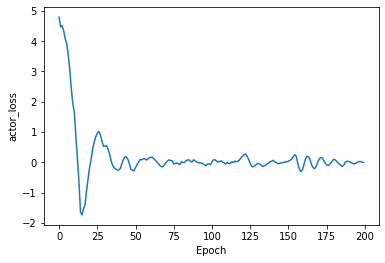

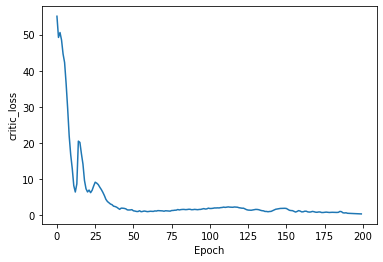

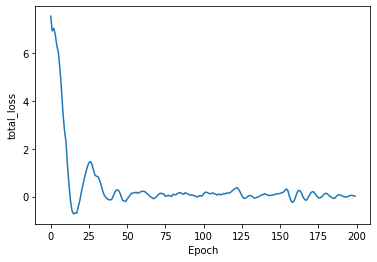

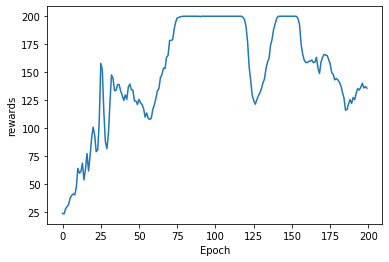

In [12]:
agent.plot_train_stats()

In [14]:
# watch the trained agent
env = wrap_env(gym.make(env_to_use))
state = env.reset()
done=False
while not done:
    policy, _ = agent.get_net_op(state)
    action = agent.get_action(policy)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()
show_video()